# Ranked score

In [1]:
import os
import numpy as np
import torch
from specvae.model import BaseModel
import specvae.dataset as dt
import specvae.utils as utils

In [2]:
# Parameters
dataset = 'MoNA'
modelpath = "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-800-200-50-3-50-200-800-20_01 (24-12-2021_01-50-12)"
# model_dirs = [
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-800-200-50-3-50-200-800-20_01 (24-12-2021_01-50-12)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-400-100-3-400-20_02 (24-12-2021_03-34-34)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-1600-3-1600-20_03 (24-12-2021_00-17-31)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-800-3-800-20_04 (24-12-2021_00-25-10)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-100-3-90-100-20_05 (24-12-2021_03-01-19)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_50-400-3-100-400-50_06 (24-12-2021_06-19-49)"
# ]

In [3]:
device, cpu = utils.device(use_cuda=False)

Device in use:  cpu


In [4]:
def load_model(path):
    model_path = os.path.join(path, 'model.pth')
    model = BaseModel.load(model_path, device)
    model.eval()
    return model

In [5]:
base_path = utils.get_project_path() / '.data' / dataset
metadata_path = base_path / ('%s_meta.npy' % dataset)

metadata = None
if os.path.exists(metadata_path):
    metadata = np.load(metadata_path, allow_pickle=True).item()

df = dt.Spectra.open(base_path / ('%s_full.csv' % dataset))

In [6]:
def preload_data_as_tensor(model, df, n=-1):
    columns = model.config['input_columns']
    types = model.config['types']
    data = dt.Spectra.preload_tensor(
        device=device, data_frame=df[columns + ['id']], transform=model.transform, limit=n, types=types,   do_print=False)
    return data

In [7]:
def evaluate_model(model, df, data):
    print("Encode N=%d instances from %s dataset..." % (data['id'].shape[0], dataset))
    X, ids = data['spectrum'], data['id'] # TODO: handle the case for concatanated input
    Xrecon, z, latent_dist = model.forward_(X)
    print(z.shape)
    data_np = {}
    data_np['X'] = X.data.cpu().numpy()
    data_np['Xrecon'] = Xrecon.data.cpu().numpy()
    data_np['z'] = z.data.cpu().numpy()
    data_np['ids'] = ids
    data_np['ionization_mode_id'] = df['ionization_mode_id'].to_numpy()
    data_np['collision_energy'] = df['collision_energy'].to_numpy()
    if 'instrument_type' in df:
        data_np['instrument_type'] = df['instrument_type'].to_numpy()
    # data_np['images'] = df['images'].to_numpy()
    return data_np


In [8]:
print('Path:', modelpath)
model = load_model(modelpath)
model

Path: d:\Workspace\SpecVAE\.model\MoNA\betavae_capacity_nextron\betavae_capacity_20-800-200-50-3-50-200-800-20_01 (24-12-2021_01-50-12)


SpecVEA(
  (encoder): Sequential(
    (en_lin_1): Linear(in_features=20, out_features=800, bias=True)
    (en_lin_batchnorm_1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (en_act_1): ReLU()
    (en_lin_2): Linear(in_features=800, out_features=200, bias=True)
    (en_lin_batchnorm_2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (en_act_2): ReLU()
    (en_lin_3): Linear(in_features=200, out_features=50, bias=True)
    (en_lin_batchnorm_3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (en_act_3): ReLU()
  )
  (fc_mean): Linear(in_features=50, out_features=3, bias=True)
  (mean_batchnorm): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_logvar): Linear(in_features=50, out_features=3, bias=True)
  (logvar_batchnorm): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sample): SampleZ()
  (decoder): Seque

In [9]:
data = preload_data_as_tensor(model, df, n=5000)

In [10]:
data = evaluate_model(model, df, data)

Encode N=5002 instances from MoNA dataset...
torch.Size([5002, 3])


In [11]:
from specvae.metrics import cos_sim, eu_dist, per_diff

def ranked_score(X, Y, score_fun=cos_sim):
    A = score_fun(X, Y, matrix=True)
    As = torch.argsort(A, dim=1, descending=True if score_fun == cos_sim else False)
    diag = torch.arange(start=0, end=As.shape[0], dtype=int).repeat(As.shape[0], 1).T
    x, y = torch.where(As == diag)
    y = y.to(float).detach().numpy()
    return y

In [12]:
X, Xr = torch.from_numpy(data['X']), torch.from_numpy(data['Xrecon'])
cs_r = ranked_score(X, Xr, score_fun=cos_sim)
eu_r = ranked_score(X, Xr, score_fun=eu_dist)
pd_r = ranked_score(X, Xr, score_fun=per_diff)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2001600320 bytes.

In [ ]:
np.median(cs_r), cs_r.mean(), cs_r.std()

(1.0, 8.10435825669732, 42.84220492912013)

In [ ]:
np.median(eu_r), eu_r.mean(), eu_r.std()

(1.0, 8.105557776889244, 42.84210866179354)

In [ ]:
np.median(pd_r), pd_r.mean(), pd_r.std()

(18.0, 95.92782886845262, 208.05947488929175)

In [ ]:
# n = 20000
# cos_sim: 31.8712, 205.5470
# eu_dist: 26.4113, 151.3936
# per_diff: 

# n = 10000
# cos_sim: 16.3766, 90.6407
# eu_dist: 13.9536, 71.2896
# per_diff: 149.4847, 402.5069

# n = 5000
# cos_sim: 8.1050, 42.8465
# eu_dist: 7.0372, 34.6735
# per_diff: 89.7121, 200.8601


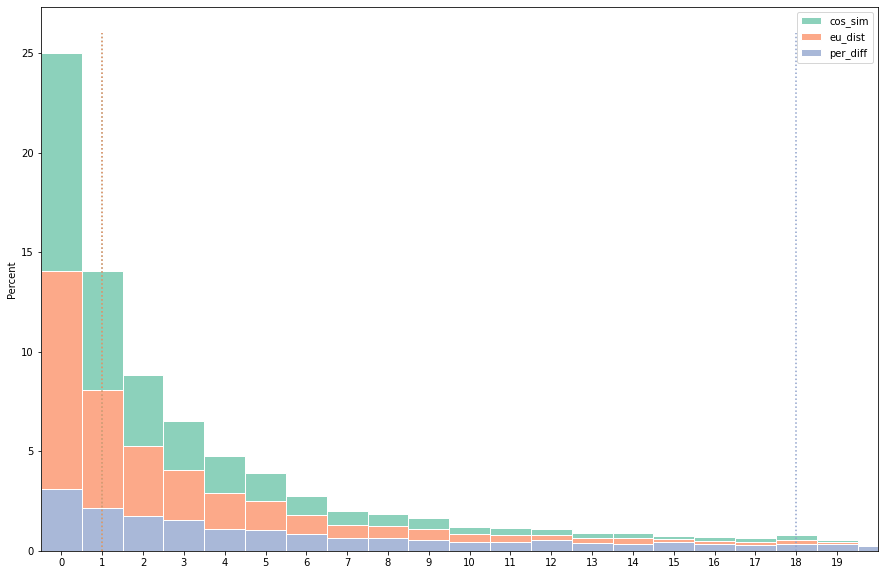

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

xlim = 20
cm = get_cmap('Set2')
scores = pd.DataFrame(data={'cos_sim': cs_r, 'eu_dist': eu_r, 'per_diff': pd_r})

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.histplot(data=scores, multiple='stack', stat='percent', discrete=True, edgecolor='white', linewidth=1., ax=ax, palette='Set2')
ax.set_xlim(-0.5, xlim)

t = ax.set_xticks(np.arange(0, xlim, dtype=int))
_ = ax.vlines(x=np.median(cs_r), ymin=0, ymax=26, ls=':', colors=cm(0), label='median - cos_sim')
_ = ax.vlines(x=np.median(eu_r), ymin=0, ymax=26, ls=':', colors=cm(1), label='median - eu_dist')
_ = ax.vlines(x=np.median(pd_r), ymin=0, ymax=26, ls=':', colors=cm(2), label='median - per_diff')


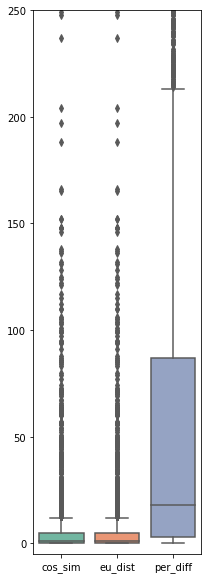

In [ ]:
fig, ax = plt.subplots(figsize=(3, 10))
ax = sns.boxplot(data=scores, ax=ax, orient='v', palette='Set2')
# _ = ax.set_yscale('log')
_ = ax.set_ylim(-5, 250)